## Introducción

Entrenamiento de modelo preentrenado para resolver el problema de predecir el ángulo del auto en base a la imagen.

Fuertemente basado en:
- https://towardsdatascience.com/a-practical-example-in-transfer-learning-with-pytorch-846bb835f2db
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html 

## Imports

In [82]:
import sys
sys.path.append('../')

import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torchmetrics import MetricCollection, Accuracy, Precision, Recall, F1, ConfusionMatrix
import pandas as pd
import sklearn
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime
import os

import importlib
from dataset_modules.one_part_dataset import OnePartDataset
import metrics_helper

importlib.reload(metrics_helper)

<module 'metrics_helper' from '/Users/fcuevas/Documents/fing/tesis/jupyters/interpretability/../metrics_helper.py'>

## Variables

In [83]:
MODEL_FILE = "resnet50_paragolpe_fine_tuning-norepairs.pth"
FEATURE_EXTRACTION = False
device_string = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_string)

if device_string == "cuda":
    print("Usando GPU!")

## Cargar Modelo

En este step se carga el modelo.

In [84]:
model = models.resnet50(pretrained=True)
NUM_CLASSES = len(classes)

model.fc = torch.nn.Linear(2048, NUM_CLASSES)
model = model.to(device)

model.load_state_dict(torch.load(MODEL_FILE, map_location=device))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Intepretación

In [85]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import SmoothGradCAMpp
cam_extractor = SmoothGradCAMpp(model)

In [89]:
image_name = "/M313291/M313291003.jpg"

In [90]:
# Get your input
img = read_image("../dataset_modules/imgs/{}".format(image_name))

# Preprocess it for your chosen model
img_transform = transforms.Compose([
        transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

input_tensor = img_transform(to_pil_image(img))

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

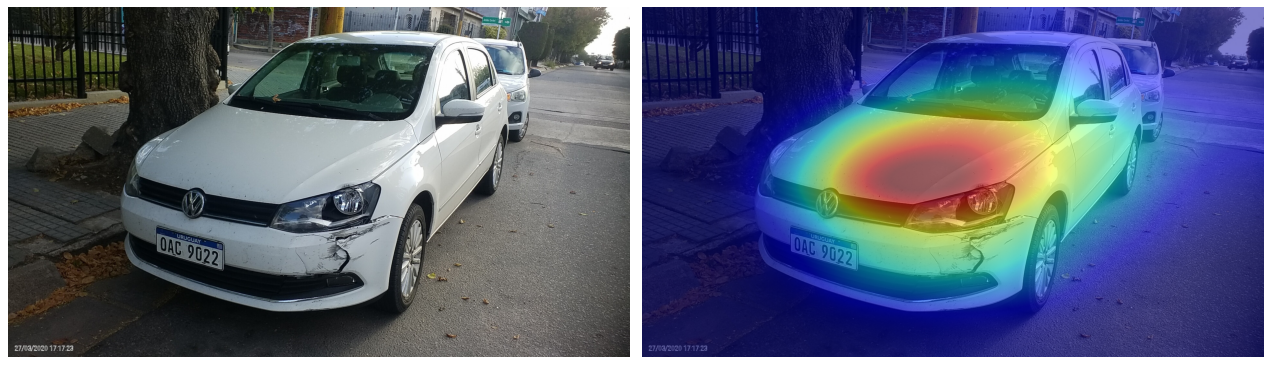

In [91]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0], mode='F'), alpha=0.5)
# Display it
f = plt.figure(figsize=(16, 12), dpi=80)
f.add_subplot(1,2, 1)
plt.imshow(to_pil_image(img))
plt.axis('off')
f.add_subplot(1,2, 2)
plt.imshow(result)
plt.axis('off'); plt.tight_layout(); plt.show()